# The challenge
The competition is simple: we want you to use the Titanic passenger data (name, age, price of ticket, etc) to try to predict who will survive and who will die.

## Data
Original: https://www.kaggle.com/competitions/titanic/data

**Data Dictionary**
1. survival - 0 = No, 1 = Yes
2. pclass -	Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
3. sex
4. Age
5. sibsp - # of siblings / spouses aboard the Titanic	
6. parch - # of parents / children aboard the Titanic	
7. ticket - Ticket number	
8. fare - Passenger fare	
9. cabin - Cabin number	
10. embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

**Variable Notes**\
**pclass**: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5\
**sibsp**: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson\
Some children travelled only with a nanny, therefore parch=0 for them.\

## Import tools

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

## Load and explore data

In [6]:
df_original = pd.read_csv('data/train.csv')
df_original

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
df = df_original.copy()

In [8]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


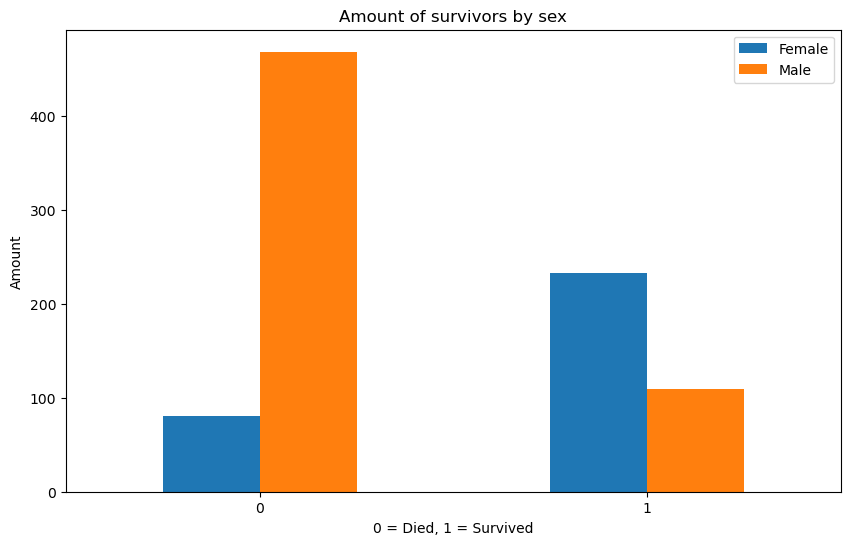

In [10]:
pd.crosstab(df.Survived, df.Sex).plot.bar(figsize=(10, 6))
plt.title("Amount of survivors by sex")
plt.xlabel("0 = Died, 1 = Survived")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);
plt.xticks(rotation=0);

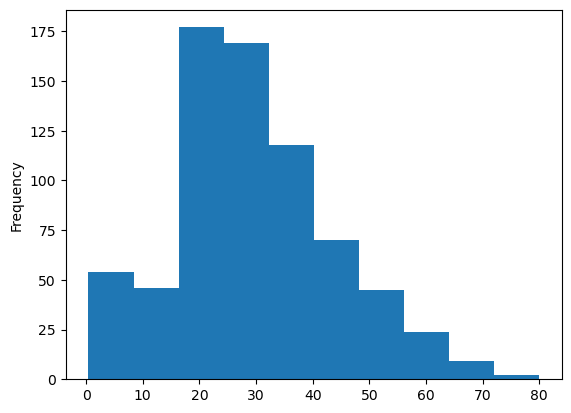

In [11]:
df.Age.plot.hist();

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_11852\3217717285.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


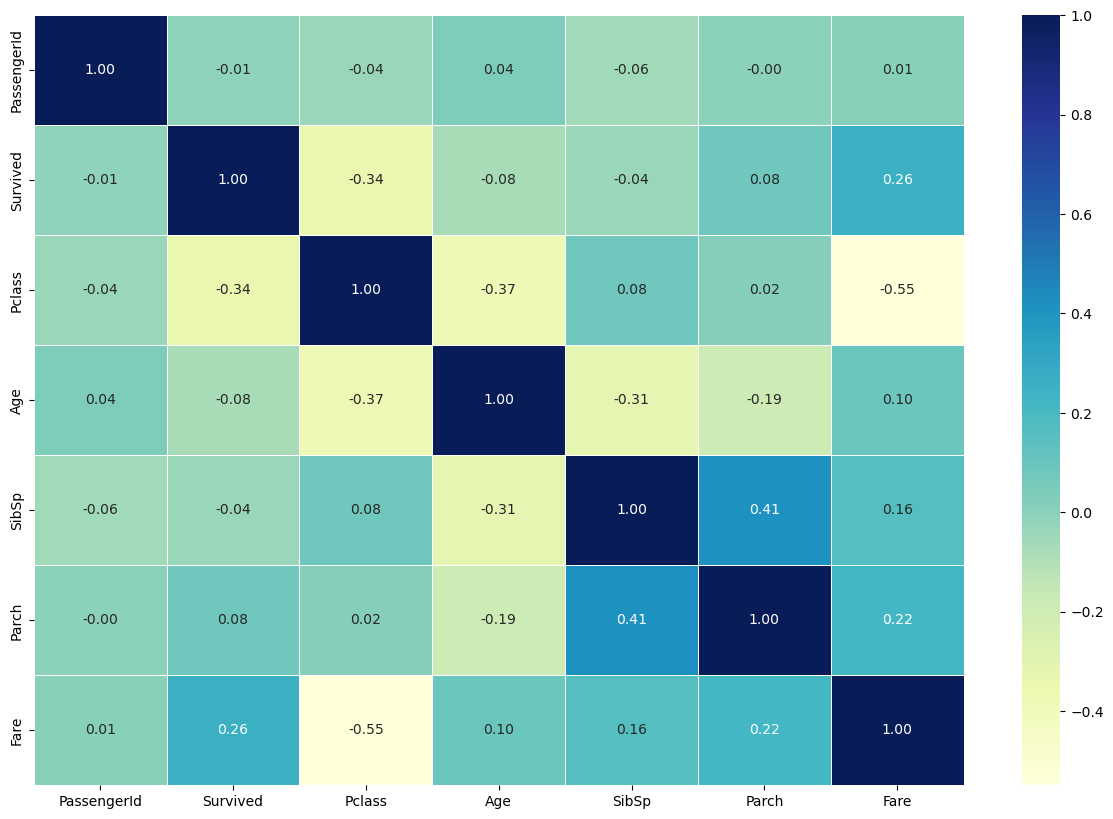

In [12]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

In [13]:
from sklearn.preprocessing import OneHotEncoder

def preprocess(df_original):
    df = df_original.copy()
    # Fill null values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    df.drop(['PassengerId', 'Ticket', 'Name', 'Cabin', 'SibSp', 'Parch'], axis=1, inplace=True)
    
    categorical_features = ["Embarked", "Sex", "Pclass"]

    encoder = OneHotEncoder()
    encoder_df = pd.DataFrame(encoder.fit_transform(df[categorical_features]).toarray())
    encoder_df.columns = encoder.get_feature_names_out(categorical_features)

    df = df.join(encoder_df)
    
    df.drop(categorical_features, axis=1, inplace=True)
    
    return df

In [14]:
df = preprocess(df_original)
df

,Survived,Age,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,7.2500,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,71.2833,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,26.0,7.9250,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,53.1000,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0,35.0,8.0500,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,13.0000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
887,1,19.0,30.0000,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
888,0,28.0,23.4500,3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
889,1,26.0,30.0000,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [15]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [16]:
X

,Age,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,22.0,7.2500,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,71.2833,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,26.0,7.9250,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,35.0,53.1000,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,35.0,8.0500,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
887,19.0,30.0000,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
888,28.0,23.4500,3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
889,26.0,30.0000,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [18]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

In [19]:
def fit_n_score(models, X_train, X_val, y_train, y_val):
    scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        scores[name] = model.score(X_val, y_val)
    return scores

In [20]:
scores = fit_n_score(models, X_train, X_val, y_train, y_val)
scores

D:\Desktop\ml\env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8379888268156425,
 'KNN': 0.7318435754189944,
 'Random Forest': 0.8268156424581006}

In [21]:
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_features": ['auto', 'sqrt'],
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [22]:
log_reg = GridSearchCV(LogisticRegression(),
                       n_jobs=-1,
                       param_grid=log_reg_grid,
                       cv=5,
                       verbose=True)

# Fit random hyperparameter search model for LogisticRegression
log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [23]:
log_reg.score(X_val, y_val)

0.8324022346368715

In [24]:
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           n_jobs=-1,
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


D:\Desktop\ml\env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Desktop\ml\env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Desktop\ml\env\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "D:\Desktop\ml\env\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "D:\Desktop\ml\env\lib\site-packages\sklearn\utils\_param_validation.py

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [25]:
rs_rf.score(X_val, y_val)

0.8491620111731844

In [26]:
rs_rf.best_params_

{'n_estimators': 760,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [27]:
gs_grid = {
    'n_estimators': np.arange(260, 360, 25),
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'max_depth': [3, 5, 10]
}

In [28]:
gs = GridSearchCV(RandomForestClassifier(),
                  n_jobs=-1,
                  param_grid=gs_grid,
                  cv=5,
                  verbose=True)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': array([260, 285, 310, 335])},
             verbose=True)

In [29]:
gs.score(X_val, y_val)

0.8659217877094972

In [30]:
y_preds = rs_rf.predict(X_val)

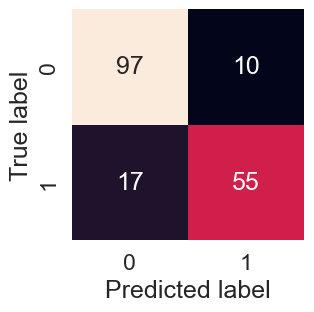

In [31]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_val, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_val, y_preds),
                     annot=True,
                     cbar=False,
                     fmt = "d")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
plot_conf_mat(y_val, y_preds)

In [32]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       107
           1       0.85      0.76      0.80        72

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



In [33]:
clf = RandomForestClassifier(n_estimators=310,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_depth=5)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=16, n_estimators=310)

In [34]:
clf.score(X_val, y_val)

0.8547486033519553

In [35]:
import pickle

pickle.dump(clf, open("random_forest_model.pkl", "wb"))